In [8]:
# https://www.youtube.com/watch?v=frM_7UMD_-A
# 隔离森林 isolated forest algorithm
# 特征经过 PCA 转换，仅包含数值型变量（V1-V28），
# 加上时间（Time）和交易金额（Amount），
# 目标变量是二分类标签（Class：0 表示正常，1 表示欺诈）。
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
import scipy
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report, accuracy_score
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from pylab import rcParams
rcParams['figure.figsize'] = (14, 8)
rcParams['font.sans-serif'] = 'SimHei'
rcParams['axes.unicode_minus'] = False
LABELS = ['Normal', 'Fraud']
RANDOM_SEED = 42

In [18]:
data_path = r'../data/kaggle-creditcard.csv'
data = pd.read_csv(data_path)

# 检查是否有缺失值
print(data.info())
print("--" * 20)
print(f"表格是否有缺失值：{data.isnull().values.any()}")
print("--" * 20)
print(data.tail(10))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

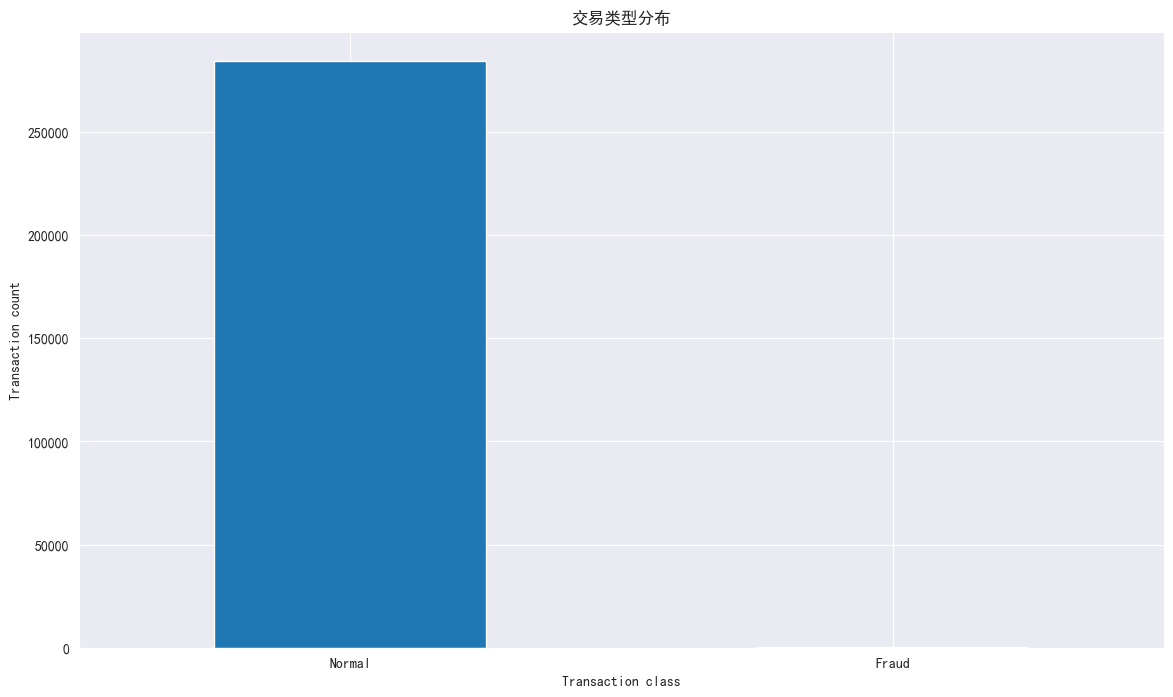

In [11]:
class_count = data['Class'].value_counts(sort=True)
class_count.plot(kind='bar', rot=0)
plt.title("交易类型分布")
plt.xticks(range(2), LABELS)
plt.xlabel("Transaction class")
plt.ylabel("Transaction count")
plt.show()

In [13]:
fraud = data.query('Class == 1')
normal = data.query('Class == 0')
print("--" * 20)
print(f"欺诈交易样本数据形状：{fraud.shape}")
print("--" * 20)
print(f"正常交易样本数据形状：{normal.shape}")
print("--" * 20)

----------------------------------------
欺诈交易样本数据形状：(492, 31)
----------------------------------------
正常交易样本数据形状：(284315, 31)
----------------------------------------


In [14]:
# 欺诈交易的金额分布
fraud.Amount.value_counts()

Amount
1.00      113
99.99      27
0.00       27
0.76       17
0.77       10
         ... 
188.78      1
3.12        1
717.15      1
3.76        1
529.00      1
Name: count, Length: 259, dtype: int64

In [15]:
# 正常交易的金额分布
normal.Amount.value_counts()

Amount
1.00        13575
1.98         6044
0.89         4872
9.99         4746
15.00        3280
            ...  
336.33          1
491.30          1
267.60          1
10199.44        1
636.48          1
Name: count, Length: 32701, dtype: int64

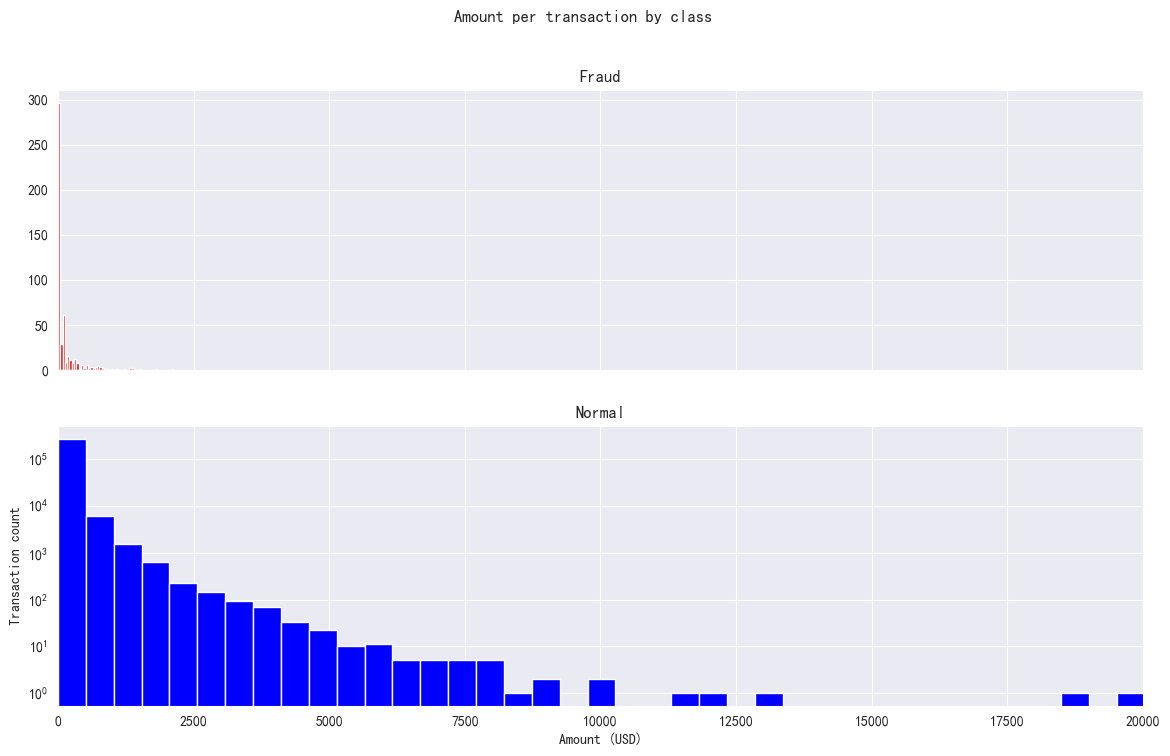

In [16]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
fig.suptitle('Amount per transaction by class')
ax1.hist(fraud.Amount, bins=50, color='red')
ax1.set_title('Fraud')
ax2.hist(normal.Amount, bins=50, color='blue')
ax2.set_title('Normal')
plt.xlabel('Amount (USD)')
plt.ylabel('Transaction count')
plt.xlim(0, 20000)
plt.yscale('log')
plt.show()

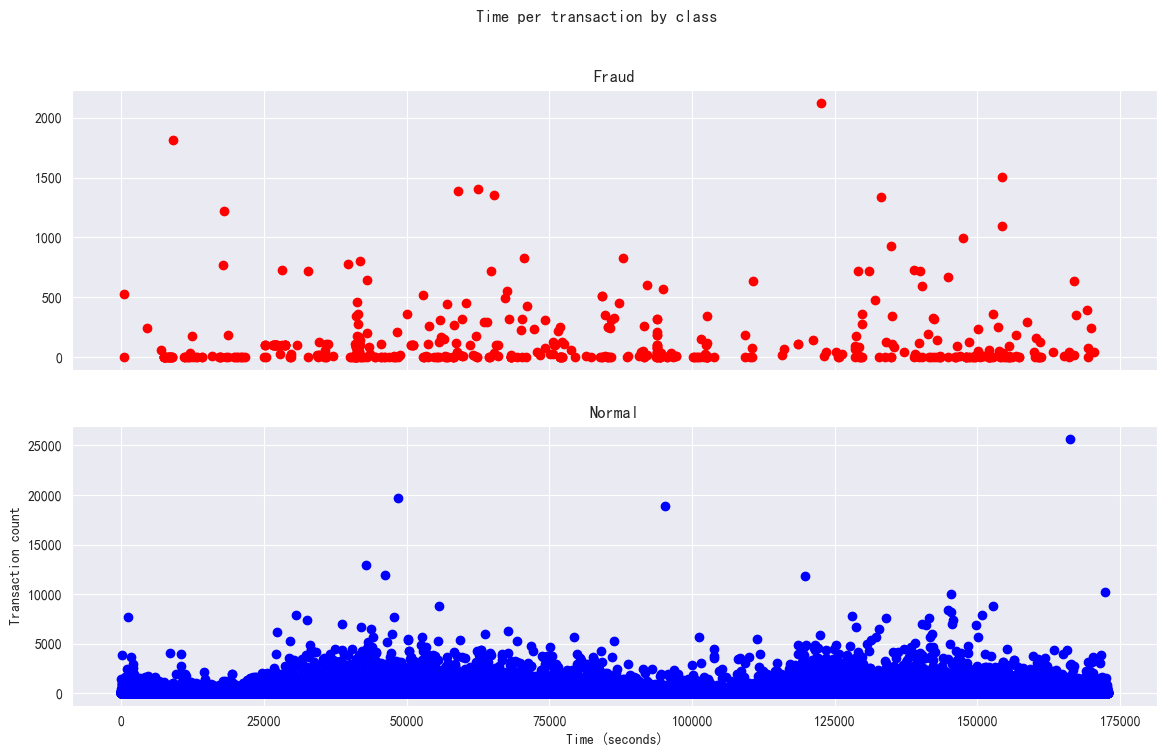

In [17]:
# 欺诈交易的时间分布
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
fig.suptitle('Time per transaction by class')
ax1.scatter(fraud.Time, fraud.Amount, color='red')
ax1.set_title('Fraud')
ax2.scatter(normal.Time, normal.Amount, color='blue')
ax2.set_title('Normal')
plt.xlabel('Time (seconds)')
plt.ylabel('Transaction count')
plt.show()

In [20]:
# 数据拆分
data1 = data.sample(frac=0.1, random_state=RANDOM_SEED)
data1.shape, data.shape

((28481, 31), (284807, 31))

In [22]:
Fraud = data1.query('Class == 1')
Valid = data1.query('Class == 0')
outlier_fraction = len(Fraud) / float(len(Valid))
print(outlier_fraction)
print(f"欺诈样本：{len(Fraud)}")
print(f"正常样本：{len(Valid)}")

0.001617724635132759
欺诈样本：46
正常样本：28435


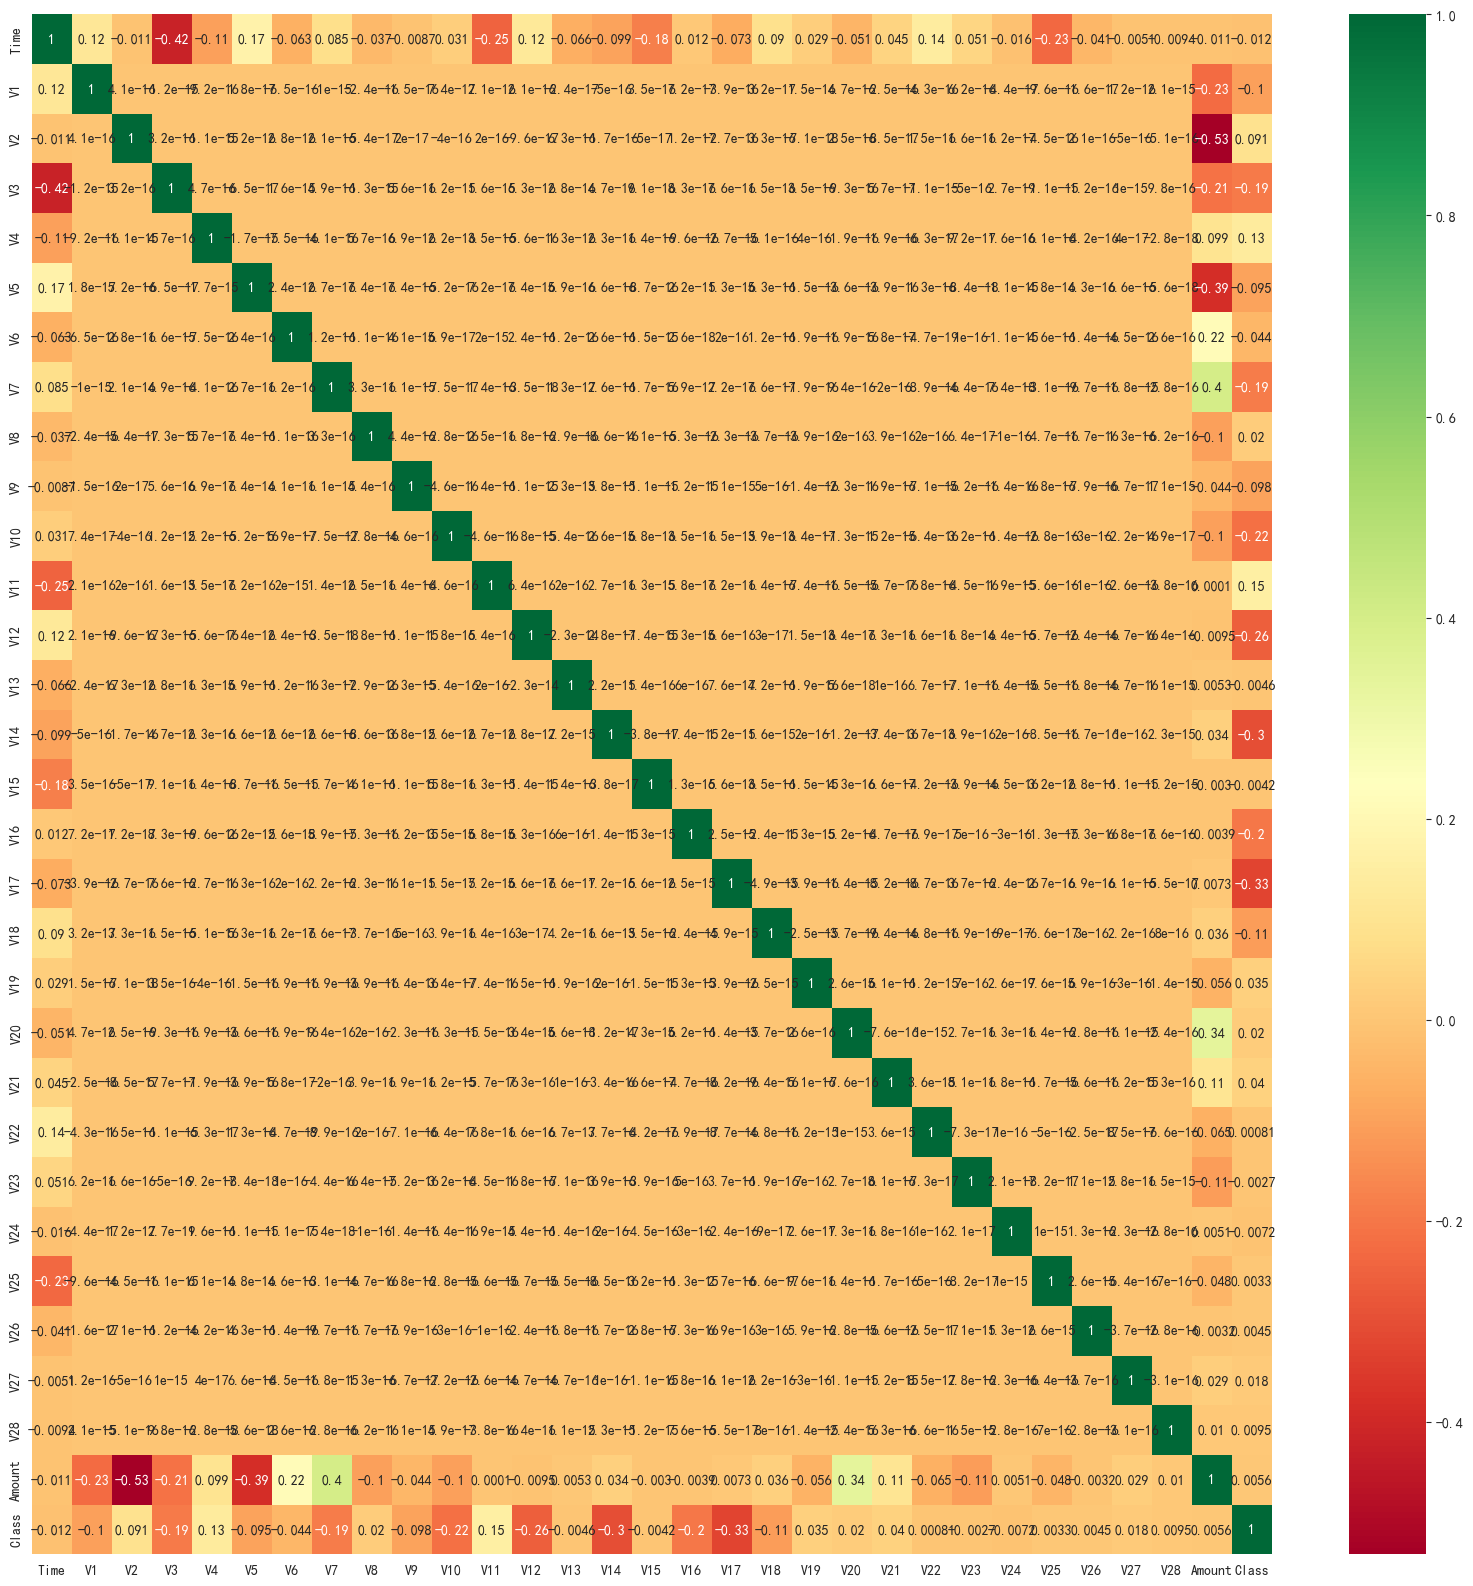

In [23]:
# 特征相关性
corr = data1.corr()
top_corr_features = corr.index
plt.figure(figsize=(20, 20))
g = sns.heatmap(data[top_corr_features].corr(), annot=True, cmap='RdYlGn')

In [27]:
columns = data1.columns.tolist()
print(columns)
print("--" * 20)
columns = [c for c in columns if c not in ['Class']]
print(columns)
target = 'Class'
random_state = np.random.RandomState(RANDOM_SEED)
X = data1[columns].values
y = data1[target].values
X_outliers = random_state.uniform(low=0, high=1, size=X.shape)
print(X.shape, y.shape)

['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount', 'Class']
----------------------------------------
['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount']
(28481, 30) (28481,)


In [ ]:
# 真阳性：TP
# 真阴性：TN
# 假阳性（误报率）：FP
# 漏报率：FN
# 准确率：TP / (TP + FP)
# 精确率：TP / (TP + FN)
# 召回率：TP / (TP + TN)
# F1-score：2 * (精确率 * 召回率) / (精确率 + 召回率)
